In [1]:
# Import necessary packages
import pandas
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d')

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

In [2]:
def pred_plot(x):
    # Create figure and plot space
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
    y = x.resample("3H").sum()
    y.drop(y.tail(1).index,inplace=True)
    y.drop(y.head(1).index,inplace=True)

    cols = ["EN","INTL","NOLANG"]
    for i in range(len(cols)):
        # Add x-axis and y-axis
        ax[0,i].scatter(x.index.values,
                x[cols[i]],
                color='purple')
        
        ax[0,i].xaxis.set_major_formatter(myFmt)

        # Set title and labels for axes
        ax[0,i].set(xlabel="Date",
            ylabel=cols[i] + " candidates",
            title="RAW sample data")

        ax[0,i].axvline(pandas.to_datetime('2021-11-19T08:00'), color='r', linestyle='--', lw=2, label="dedup fixed")
        ax[0,i].axvline(pandas.to_datetime('2021-11-26T22:00'), color='b', linestyle='--', lw=2, label="power outage")
        ax[0,i].axvline(pandas.to_datetime('2021-11-27T15:00'), color='g', linestyle='--', lw=2, label="cc extended")
        
        # fit least-squares with an intercept
        y_values = x.loc[:, cols[i]]
        x_values = np.linspace(0,1,len(x.loc[:, cols[i]]))
        poly_degree = 5

        coeffs = np.polyfit(x_values, y_values, poly_degree)
        poly_eqn = np.poly1d(coeffs)
        y_hat = poly_eqn(x_values)
        ax[0,i].plot(x.index,y_hat)

    for i in range(len(cols)):
        # Add x-axis and y-axis
        ax[1,i].scatter(y.index.values,
                40*y[cols[i]],
                color='red')
        ax[1,i].xaxis.set_major_formatter(myFmt)

        # Set title and labels for axes
        ax[1,i].set(xlabel="Date",
            ylabel=cols[i] + " candidates",
            title="3 hours resampled data")

        ax[1, i].axvline(pandas.to_datetime('2021-11-19T10:00'), color='r', linestyle='--', lw=2, label="dedup fixed")
        
        # fit least-squares with an intercept
        y_values = 40*y.loc[:, cols[i]]
        x_values = np.linspace(0,1,len(y.loc[:, cols[i]]))
        poly_degree = 5

        coeffs = np.polyfit(x_values, y_values, poly_degree)
        poly_eqn = np.poly1d(coeffs)
        y_hat = poly_eqn(x_values)
        ax[1, i].plot(y.index,y_hat)


    fig.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    fig.tight_layout()

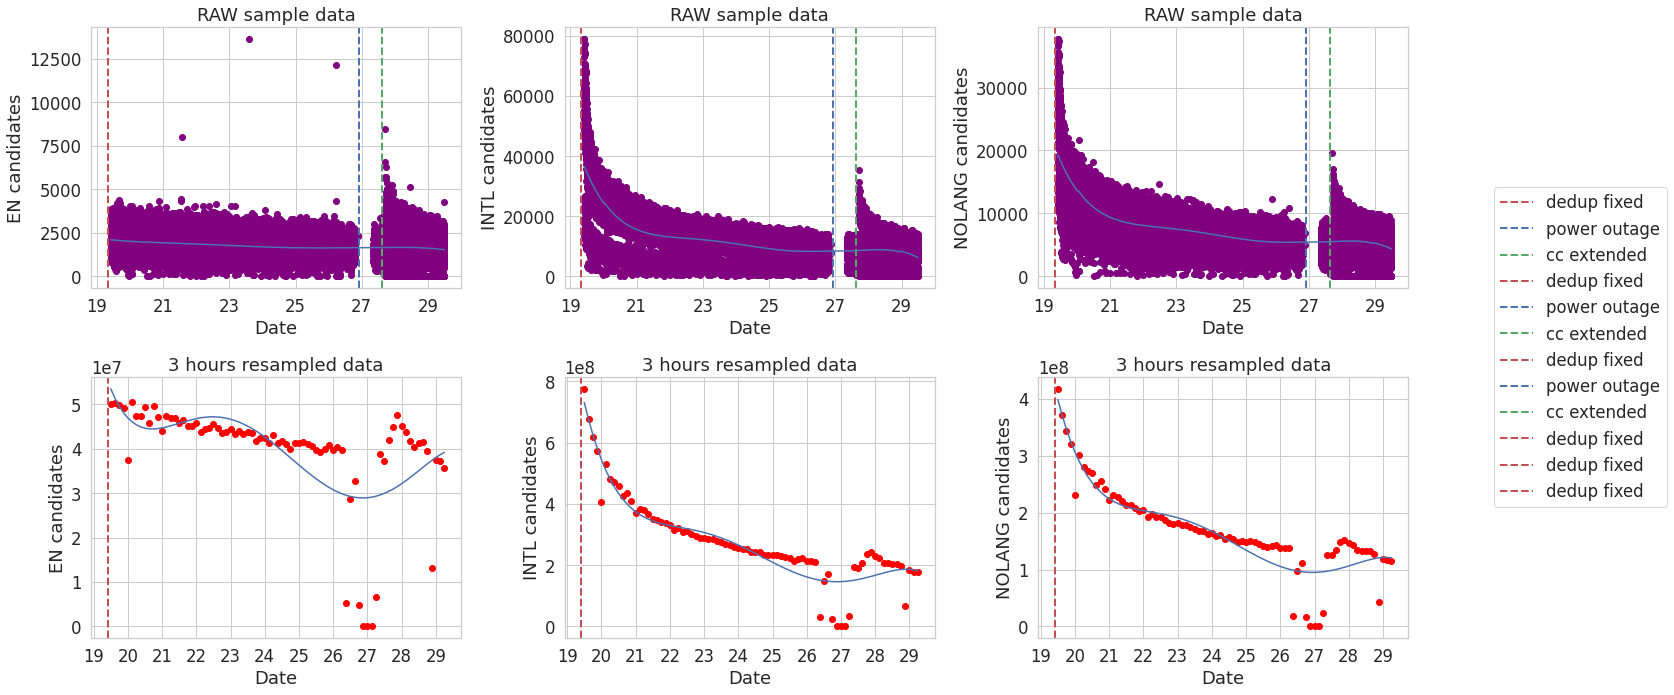

In [3]:
# Create figure and plot space
x = pandas.read_csv('../datapoints.txt',delimiter='\t', parse_dates=True, date_parser=dateparse, index_col='DateTime', names=['DateTime', 'EN', 'INTL', "NOLANG"], header=None)
x = x[x.index>pandas.to_datetime('2021-11-19T10:00')] # use only data after deduplication bug fixing
pred_plot(x)

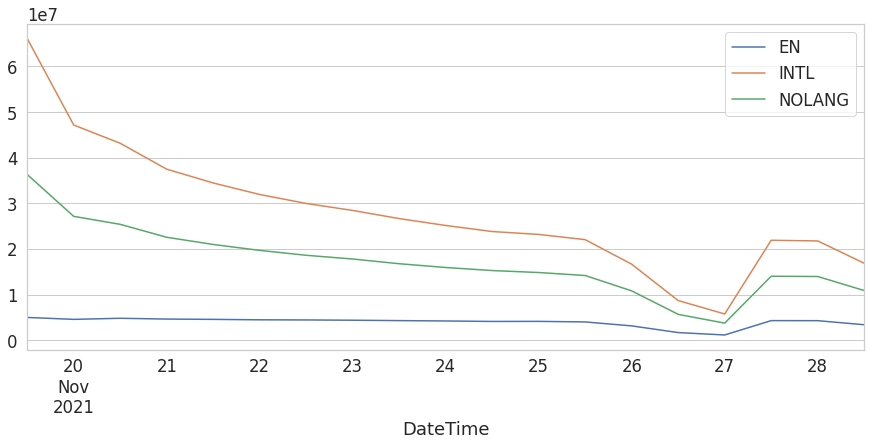

In [4]:
z = x.resample('12H').sum()
z.drop(z.head(1).index,inplace=True)
z.drop(z.tail(1).index,inplace=True)
z.plot(figsize=(15, 6))
plt.show()


In [5]:
y_to_train = z[:'2021-11-22T12:00'] # dataset to train
y_to_val = z['2021-11-23':] # last X months for test  
predict_date = 4.2*(len(z) - len(z[:'2021-11-22T12:00'])) # the number of data points for the test set

In [6]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date, colname):
    y[colname].plot(marker='o', color='black', legend=True, figsize=(14, 7))

    fit2 = Holt(y_to_train[colname], exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test[colname]) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    # because data is sampled as 1/40 ratio, we multiply the total with 40 below
    print(f"Language: {colname}")
    print(f"Total candidates: {round(int(fcast2.sum()*40)/1000000000, 2)} billions")
    print(f"Total samples after CLIP*: {round(int(fcast2.sum()*40)/10000000000,2)} billions")
    print("* 10% estimation is done with only English CLIP, still no data for multilingual MCLIP")

    plt.show()

The Root Mean Squared Error of Holts Exponential trend 1072386.64
Language: EN
Total candidates: 6.21 billions
Total samples after CLIP*: 0.62 billions
* 10% estimation is done with only English CLIP, still no data for multilingual MCLIP


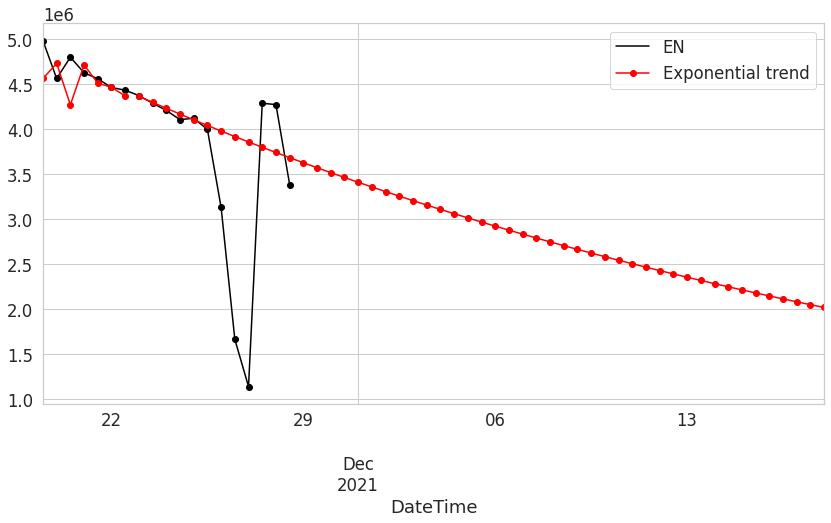

The Root Mean Squared Error of Holts Exponential trend 5454440.41
Language: INTL
Total candidates: 21.18 billions
Total samples after CLIP*: 2.12 billions
* 10% estimation is done with only English CLIP, still no data for multilingual MCLIP


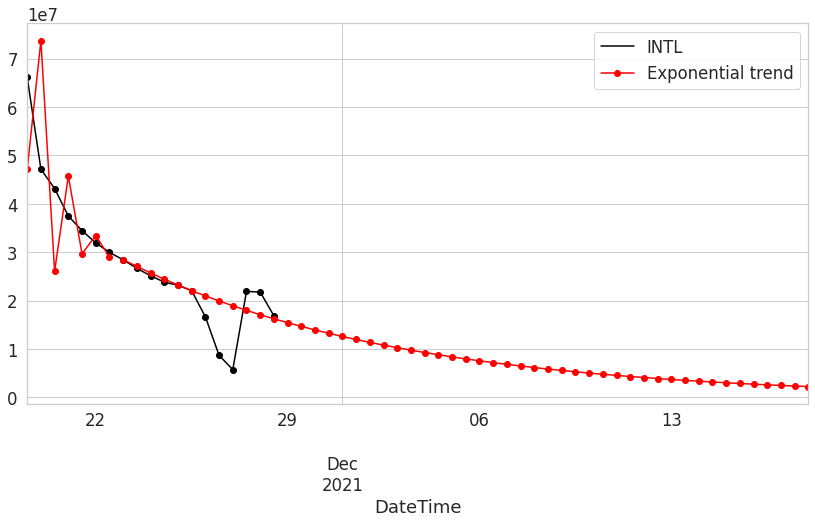

The Root Mean Squared Error of Holts Exponential trend 3456386.77
Language: NOLANG
Total candidates: 14.1 billions
Total samples after CLIP*: 1.41 billions
* 10% estimation is done with only English CLIP, still no data for multilingual MCLIP


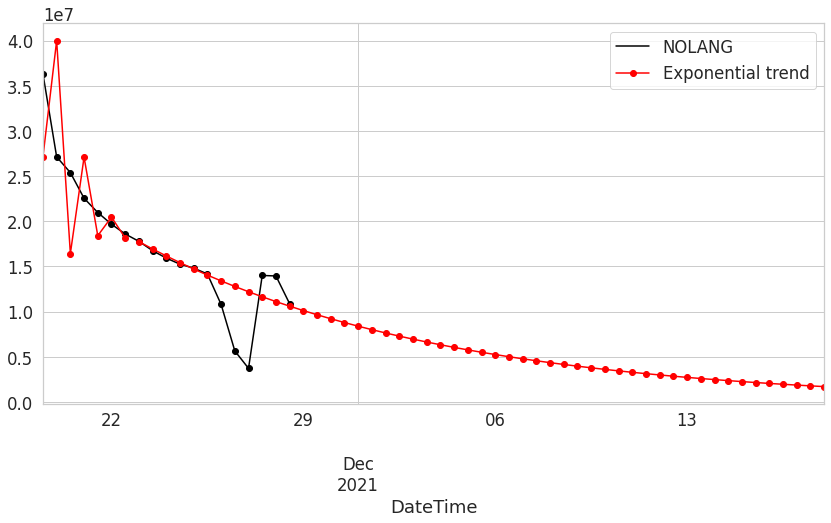

In [7]:
holt(z, y_to_train,y_to_val,1.,0.4,predict_date,'EN')
holt(z, y_to_train,y_to_val,1.,1.4,predict_date,'INTL')
holt(z, y_to_train,y_to_val,1.,1.4,predict_date,'NOLANG')